In [11]:
rnd = 42
import random
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import transformers
assert transformers.__version__=='2.7.0', 'Please install transformer 2.7.0 (You may need a rust compiler https://rustup.rs/)'
import folium
assert folium.__version__=='0.2.1'
import urllib3
assert urllib3.__version__=='1.25.4'
import captum

DEVICE = 'cuda'
dataset = 'IMDB'

In [17]:
download_file_from_google_drive('1hmuG2EFgEQmIA2lCeDZ4pG69KneVIFOS','./data/Text/text_datasets.zip')
os.system('unzip ./data/text/text_datasets.zip -d ./data/Text/')

0

In [21]:
def load_dataset(path):
    data = pd.read_csv(path)
    X = data['sentence'].values.tolist()
    Y = data['label'].values
    return X, Y

def sst_binary(data_dir='./data/Text/SST/'):
    """
    Stanford Sentiment Treebank.
    """
    trX, trY = load_dataset(os.path.join(data_dir, 'train_binary_sent.csv'))
    vaX, vaY = load_dataset(os.path.join(data_dir, 'dev_binary_sent.csv'))
    teX, teY = load_dataset(os.path.join(data_dir, 'test_binary_sent.csv'))
    return trX+vaX, teX, np.hstack((trY,vaY)), teY

def yelp_binary(data_dir='./data/Text/imdb_review_polarity/'):
    """
    Yelp Review Polarity Dataset.
    """
    trX, trY = load_dataset(os.path.join(data_dir, 'train.csv'))
    teX, teY = load_dataset(os.path.join(data_dir, 'test.csv'))
    return trX, teX, trY, teY

def imdb_binary(data_dir='./data/Text/yelp_review_polarity/'):
    """
    Imdb Review Polarity Dataset.
    """
    trX, trY = load_dataset(os.path.join(data_dir, 'train.csv'))
    teX, teY = load_dataset(os.path.join(data_dir, 'test.csv'))
    return trX, teX, trY, teY

if dataset == 'SST':
    trX, teX, trY, teY = sst_binary()
    print('SST dataset selected')
elif dataset == 'IMDB':
    trX, teX, trY, teY = imdb_binary()
    print('IMDB dataset selected')
elif dataset == 'YELP':
    trX, teX, trY, teY = yelp_binary()
    print('YELP dataset selected')

IMDB dataset selected


In [12]:
import requests

from tqdm import tqdm

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            with tqdm(unit='B', unit_scale=True, unit_divisor=1024) as bar:
                for chunk in response.iter_content(CHUNK_SIZE):
                    if chunk:  # filter out keep-alive new chunks
                        f.write(chunk)
                        bar.update(CHUNK_SIZE)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

In [15]:
if dataset == 'SST':
    download_file_from_google_drive('1RdM5-KkFuwrfv8luWoCyepBPleiNw3Py','./models/Text/SST_BERT.tgz')
    os.system('tar -zxvf ./models/Text/SST_BERT.tgz -C ./models/Text/')
elif dataset == 'IMDB':
    download_file_from_google_drive('1LwCSzbg6mts9AzuLHikoZou42-ixUuq9','./models/Text/IMDB_BERT.tgz')
    os.system('tar -zxvf ./models/Text/IMDB_BERT.tgz -C ./models/Text/')
elif dataset == 'YELP':
    download_file_from_google_drive('1udzt-GXMKzVmXxUxzYNZ7MjL7z8JcI5P','./models/Text/YELP_BERT.tar.gz')
    os.system('tar -zxvf ./models/Text/YELP_BERT.tar.gz -C ./models/Text/')

774MB [02:58, 4.54MB/s] 


In [23]:
BERT_TOKENIZER_PATH = './models/Text/'+dataset+'_BERT/BERT_base_uncased_tokenizer.pt'
BERT_PATH = './models/Text/'+dataset+'_BERT/BERT_base_uncased.pt'
BERT_FT_PATH = './models/Text/'+dataset+'_BERT/'+dataset+'_BERT_FT.pt'

BERT_tokenizer = torch.load(BERT_TOKENIZER_PATH)
BERT = torch.load(BERT_PATH)

class FT_BERT(torch.nn.Module):

    def __init__(self, BERT_model, tokenizer):
        super(FT_BERT, self).__init__()
        self.BERT = BERT_model
        self.drop = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(768, 2)
        self.log_probs = torch.nn.LogSoftmax(dim=-1)
        self.tokenizer = tokenizer

    def forward(self, input_embeds):
        #inputs = self.tokenizer.batch_encode_plus(X, add_special_tokens=True, max_length=256, pad_to_max_length=True)
        #input_ids = np.vstack(inputs['input_ids'])
        #attention_mask = np.vstack(inputs['attention_mask'])
        #token_type_ids = np.vstack(inputs['token_type_ids'])
        outputs = self.log_probs(self.linear(self.drop(self.BERT(inputs_embeds=input_embeds)[1])))
        return torch.exp(outputs)[:,1]

    def init_weights(self):
        torch.nn.init.normal_(self.linear.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(self.linear.bias,0)

from torch.utils import data

class TextDataset(data.Dataset):
    def __init__(self,trX,trY):
        self.trX = trX
        self.trY = trY

    def __len__(self):
        return len(self.trY)

    def __getitem__(self, idx):
        return (self.trX[idx],torch.tensor(self.trY[idx]))

train_data = TextDataset(trX, trY)
test_data = TextDataset(teX, teY)
train_data_loader = data.DataLoader(train_data, batch_size=32, shuffle=True)
test_data_loader = data.DataLoader(test_data, batch_size=32, shuffle=False)

model = FT_BERT(BERT,BERT_tokenizer).to(DEVICE)
device = torch.device(DEVICE)
model.load_state_dict(torch.load(BERT_FT_PATH,map_location=device))

/Users/francesco/anaconda3/envs/survey/lib/python3.7/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/francesco/anaconda3/envs/survey/lib/python3.7/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.normalization.LayerNorm' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/francesco/anaconda3/envs/survey/lib/python3.7/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. 

<All keys matched successfully>

# Saliency Matrix

In [24]:
import os
os.system('mkdir ./models/Text/BERT_no_attention')
BERT.save_pretrained('./models/Text/BERT_no_attention')

In [26]:
from transformers import BertModel, BertConfig

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig(output_attentions=True)
# Initializing a model from the bert-base-uncased style configuration
BERT = BertModel(configuration).to(DEVICE)
BERT.from_pretrained('./models/Text/BERT_no_attention/')

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

# Attention Matrix

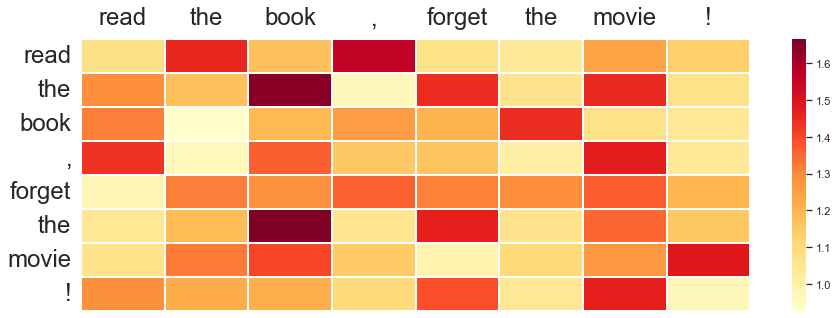

In [33]:
sentence='read the book, forget the movie!'

with torch.no_grad():
    d = BERT_tokenizer.batch_encode_plus([sentence],add_special_tokens=True,pad_to_max_length=True)
    input_embedding = model.BERT.embeddings(torch.tensor(d['input_ids']).to(DEVICE))
    output = BERT.forward(inputs_embeds=input_embedding)

attention = np.sum(output[2][0][0,:,1:-1,1:-1].detach().cpu().numpy(),axis=0)

import seaborn as sb
sb.set_theme()

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 5))
sb.heatmap(attention, annot=False, linewidths=1, ax=ax,cmap='YlOrRd')
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
ax.set_xticklabels(BERT_tokenizer.tokenize(sentence),fontsize=24)
ax.set_yticklabels(BERT_tokenizer.tokenize(sentence),fontsize=24,va='center',rotation='horizontal');

# Saliency Highlighting

### Visualisation function

In [ ]:
teX[5317]

"The movie is not that bad, Ringo Lam sucks. I hate when Van Damme has love in his movies, van Damme is good only when he doesn't have love in his movies."

In [ ]:
from IPython.core.display import display, HTML
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

bwr = cm.get_cmap('bwr', 256)

def rescale_score_by_abs (score, max_score, min_score):
    """
    rescale positive score to the range [0.5, 1.0], negative score to the range [0.0, 0.5],
    using the extremal scores max_score and min_score for normalization
    """
    
    # CASE 1: positive AND negative scores occur --------------------
    if max_score>0 and min_score<0:
    
        if max_score >= abs(min_score):   # deepest color is positive
            if score>=0:
                return 0.5 + 0.5*(score/max_score)
            else:
                return 0.5 - 0.5*(abs(score)/max_score)

        else:                             # deepest color is negative
            if score>=0:
                return 0.5 + 0.5*(score/abs(min_score))
            else:
                return 0.5 - 0.5*(score/min_score)   
    
    # CASE 2: ONLY positive scores occur -----------------------------       
    elif max_score>0 and min_score>=0: 
        if max_score == min_score:
            return 1.0
        else:
            return 0.5 + 0.5*(score/max_score)
    
    # CASE 3: ONLY negative scores occur -----------------------------
    elif max_score<=0 and min_score<0: 
        if max_score == min_score:
            return 0.0
        else:
            return 0.5 - 0.5*(score/min_score)    
  
      
def getRGB (c_tuple):
    return "#%02x%02x%02x"%(int(c_tuple[0]*255), int(c_tuple[1]*255), int(c_tuple[2]*255))

     
def span_word (word, score, colormap):
    return "<span style=\"background-color:"+getRGB(colormap(score))+"\">"+word+"</span>"

def html_heatmap (words, scores, cmap_name="bwr"):
    
    colormap  = bwr# plt.get_cmap(cmap_name)
     
    assert len(words)==len(scores)
    max_s     = max(scores)
    min_s     = min(scores)
    
    output_text = ""
    
    for idx, w in enumerate(words):
        score       = rescale_score_by_abs(scores[idx], max_s, min_s)
        output_text = output_text + span_word(w, score, colormap) + " "
    
    return output_text + "\n"

# IntGrad

In [34]:
from captum.attr import IntegratedGradients, visualization, TokenReferenceBase

ig = IntegratedGradients(model)

In [12]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model_wrapper, sentence, label=1):

    model_wrapper.eval()
    model_wrapper.zero_grad()

    input_ids = [BERT_tokenizer.encode(sentence, add_special_tokens = True, max_length=256)]
    input_embedding = model_wrapper.BERT.embeddings(torch.tensor(input_ids).to(DEVICE))

    baseline = np.array(input_ids).copy()
    baseline[0, 1:-1] = 0
    baseline_embedding = model_wrapper.BERT.embeddings(torch.tensor(baseline).to(DEVICE))

    # compute attributions and approximation delta using integrated gradients
    attributions_ig, delta = ig.attribute(input_embedding, baseline_embedding, n_steps=250, return_convergence_delta=True, internal_batch_size=128)

    return attributions_ig
    
from tqdm import tqdm_notebook as tqdm

att_igs = []

import time 
start = time.time()

for i in range(5317,5318):#tqdm(range(len(teX))):
    att_igs.append(interpret_sentence(model, teX[i]).sum(dim=-1).squeeze(0).to('cpu').detach().numpy()[1:-1])

print(time.time()-start)

3.5227432250976562


In [14]:
idx = 5317
tokens = BERT_tokenizer.tokenize(teX[idx])
scores = att_igs[0]
display(HTML('<div style="background-color:#ffffff; height:120px; font-size:36pt; color:#424242; text-align:left;"> '+html_heatmap(tokens,scores)+'</div>'))

# DeepLift

In [ ]:
from captum.attr import DeepLift, visualization, TokenReferenceBase

explainer = DeepLift(model)

In [21]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model_wrapper, sentence, label=1):

    model_wrapper.eval()
    model_wrapper.zero_grad()

    input_ids = [BERT_tokenizer.encode(sentence, add_special_tokens = True, max_length=256)]
    input_embedding = model_wrapper.BERT.embeddings(torch.tensor(input_ids).to(DEVICE))

    baseline = np.array(input_ids).copy()
    baseline[0, 1:-1] = 0
    baseline_embedding = model_wrapper.BERT.embeddings(torch.tensor(baseline).to(DEVICE))

    # compute attributions and approximation delta using integrated gradients
    attributions_ig, delta = explainer.attribute(input_embedding, baseline_embedding, return_convergence_delta=True)

    return attributions_ig

from tqdm import tqdm_notebook as tqdm
import pickle 

att = []

import time 
start = time.time()

for i in tqdm(range(5317,5318)):
    att.append(interpret_sentence(model, teX[i]).sum(dim=-1).squeeze(0).to('cpu').detach().numpy()[1:-1])

print(time.time()-start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:58: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if input.grad is not None:
/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:87: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be


0.2710409164428711


In [24]:
idx = 5317
tokens = BERT_tokenizer.tokenize(teX[idx])
scores = att[0]
display(HTML('<div style="background-color:#ffffff; height:120px; font-size:36pt; color:#424242; text-align:left;"> '+html_heatmap(tokens,scores)+'</div>'))

# Gradient x Input

In [ ]:
from captum.attr import InputXGradient, visualization, TokenReferenceBase

explainer = InputXGradient(model)

In [26]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model_wrapper, sentence, label=1):

    model_wrapper.eval()
    model_wrapper.zero_grad()

    input_ids = [BERT_tokenizer.encode(sentence, add_special_tokens = True, max_length=256)]
    input_embedding = model_wrapper.BERT.embeddings(torch.tensor(input_ids).to(DEVICE))

    # compute attributions and approximation delta using integrated gradients
    attributions_ig = explainer.attribute(input_embedding)

    return attributions_ig

from tqdm import tqdm_notebook as tqdm

att = []

import time 
start = time.time()
import pickle

for i in tqdm(range(5317,5318)):
    att.append(interpret_sentence(model, teX[i]).sum(dim=-1).squeeze(0).to('cpu').detach().numpy()[1:-1])

print(time.time()-start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0.15769386291503906


/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:58: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if input.grad is not None:
/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:87: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if inpu

In [27]:
idx = 5317
tokens = BERT_tokenizer.tokenize(teX[idx])
scores = att[0]
display(HTML('<div style="background-color:#ffffff; height:120px; font-size:36pt; color:#424242; text-align:left;"> '+html_heatmap(tokens,scores)+'</div>'))

# LIME

In [14]:
DEVICE = 'cuda'

BERT_TOKENIZER_PATH = './'+dataset+'_BERT/BERT_base_uncased_tokenizer.pt'
BERT_PATH = './'+dataset+'_BERT/BERT_base_uncased.pt'
BERT_FT_PATH = './'+dataset+'_BERT/'+dataset+'_BERT_FT.pt'

BERT_tokenizer = torch.load(BERT_TOKENIZER_PATH)
BERT = torch.load(BERT_PATH)

class FT_BERT(torch.nn.Module):

    def __init__(self, BERT_model, tokenizer):
        super(FT_BERT, self).__init__()
        self.BERT = BERT_model
        self.drop = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(768, 2)
        self.log_probs = torch.nn.LogSoftmax(dim=-1)
        self.tokenizer = tokenizer

    def forward(self, X):
        if type(X)!=list:
            X = [X]
        inputs = self.tokenizer.batch_encode_plus(X, add_special_tokens=True, max_length=256, pad_to_max_length=True)
        input_ids = np.vstack(inputs['input_ids'])
        attention_mask = np.vstack(inputs['attention_mask'])
        token_type_ids = np.vstack(inputs['token_type_ids'])
        return self.log_probs(self.linear(self.drop(self.BERT(torch.tensor(input_ids).to(DEVICE),
                                                              torch.tensor(attention_mask).to(DEVICE),
                                                              torch.tensor(token_type_ids).to(DEVICE))[1])))

    def init_weights(self):
        torch.nn.init.normal_(self.linear.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(self.linear.bias,0)

from torch.utils import data

class TextDataset(data.Dataset):
    def __init__(self,trX,trY):
        self.trX = trX
        self.trY = trY

    def __len__(self):
        return len(self.trY)

    def __getitem__(self, idx):
        return (self.trX[idx],torch.tensor(self.trY[idx]))

train_data = TextDataset(trX, trY)
test_data = TextDataset(teX, teY)
train_data_loader = data.DataLoader(train_data, batch_size=32, shuffle=True)
test_data_loader = data.DataLoader(test_data, batch_size=32, shuffle=False)

model = FT_BERT(BERT,BERT_tokenizer).to(DEVICE)
device = torch.device(DEVICE)
model.load_state_dict(torch.load(BERT_FT_PATH,map_location=device))

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.normalization.LayerNorm' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute

<All keys matched successfully>

In [20]:
class PredDataset(data.Dataset):
    def __init__(self,trX):
        self.trX = trX

    def __len__(self):
        return len(self.trX)

    def __getitem__(self, idx):
        return (self.trX[idx])

def get_sentiment(input):
    test_data = PredDataset(input)
    test_data_loader = data.DataLoader(test_data, batch_size=32, shuffle=False)
    
    y_pred = []
    for Xb in test_data_loader:   
        model.eval()
        y_pred.append(model(Xb).to('cpu').detach().numpy())
        
    return np.exp(np.vstack(y_pred))

import lime
from lime.lime_text import LimeTextExplainer

class_names = ["Negative", "Positive"]

explainer = LimeTextExplainer(class_names=class_names,split_expression='\s',bow=False,mask_string='')

import time
start = time.time()

lime_score=[]

with torch.no_grad():
    for i in range(5317,5318):#len(teX)):
        exp = explainer.explain_instance(' '.join(BERT_tokenizer.tokenize(teX[i])), get_sentiment, num_features=256, num_samples=1500)

        lime_score.append(np.hstack((np.array(exp.as_list())[:,0].reshape(-1,1), np.array(exp.as_map()[1]))).tolist())

print(time.time()-start)

48.738651275634766


In [40]:
idx = 5317
tokens = BERT_tokenizer.tokenize(teX[idx])
scores = np.stack(lime_score[0])
scores = scores[np.argsort(scores[:,1].astype(float).astype(int)),:][:,2].astype(float)
display(HTML('<div style="background-color:#ffffff; height:120px; font-size:36pt; color:#424242; text-align:left;"> '+html_heatmap(tokens,scores)+'</div>'))